### Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
from Bio import AlignIO
from Bio.Align import substitution_matrices
from Bio.Data import IUPACData
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

'''import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser'''

from pathlib import Path
import os

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Creating the path to the main folder we are going to use to create our datasets

In [2]:
# Path to train data
training_data_path = Path('../data/train')

# Path to test data
test_data_path = Path('../data/test')

# Path to baseline data
baseline_data_path = Path('../data/baseline')


# Training Set

In this section we are **creating the Training Set**, fusing togheter the data from:
- _train_set.tsv_
- _train_ids.txt_
- _train.fasta_
- _train_embeddings.h5_
- _train_protein2ipr.dat_
- _go-basic.obo_

### Extracting `train_set.tsv`

In [3]:
train_set = pd.read_csv(training_data_path / 'train_set.tsv', sep='\t')

# Rename Protein_ID and aspect columns
train_set.rename(columns={'Protein_ID': 'ID', 'aspect' : 'sub_ontology'}, inplace=True)

# Display the first few rows of the train set
train_set.head()

ID        sub_ontology     GO_term
0  P91124  cellular_component  GO:0005575
1  P91124  cellular_component  GO:0110165
2  P91124  cellular_component  GO:0005737
3  P91124  cellular_component  GO:0005622
4  P91124  cellular_component  GO:0043226

### Extracting `train_ids.txt`

In [4]:
# Extracting train_ids.txt
with open(training_data_path / 'train_ids.txt', 'r') as file:
    train_ids = file.read().splitlines()

# Display the first few IDs to verify
print(train_ids[:5])

['P91124', 'Q55DL5', 'O81027', 'Q04418', 'Q8IXT2']


In [5]:
if len(train_ids) == len(train_set['ID'].unique()):
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(train_ids)}).\n"
          "Proceeding with the analysis.")

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (123969).
Proceeding with the analysis.


### Extracting `train.fasta`

In [6]:
train_fasta_list = list(SeqIO.parse(training_data_path / 'train.fasta', 'fasta'))

# Print the first sequence to verify
print(train_fasta_list[0])

ID: P91124
Name: P91124
Description: P91124
Number of features: 0
Seq('MAAQFYERNTSGMNADRFMTRLTDESTVNTMQRHYWTARQFIRTKLGKKEDEHL...NLL')


Let's transform it into a DataFrame

In [7]:
# Extract relevant information from SeqRecord
train_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in train_fasta_list]

# Create a DataFrame from the extracted data
train_fasta = pd.DataFrame(train_fasta_dict)

# Display the DataFrame
train_fasta.head()

ID    name description  num_features  \
0  P91124  P91124      P91124             0   
1  Q55DL5  Q55DL5      Q55DL5             0   
2  O81027  O81027      O81027             0   
3  Q04418  Q04418      Q04418             0   
4  Q8IXT2  Q8IXT2      Q8IXT2             0   

                                            sequence  
0  (M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ...  
1  (M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ...  
2  (M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ...  
3  (M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ...  
4  (M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ...

Checking if `ID`, `name` and `description` have the same information

In [8]:
# Checking for differences between the ID and name columns
diff_id_name = sum(train_fasta['ID'] != train_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(train_fasta['ID'] != train_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


Checking if `num_features` has value different from 0

In [9]:
num_features_values = sum(train_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


**Nice!**

We found that `ID`, `name` and `description` columns are the same. We can remove two of them (`name`, `descritpion`). 

In the same way we saw that `num_features` is not very informative since it has only 0, let's remove it as well



In [10]:
train_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


train_fasta.head()

ID                                           sequence
0  P91124  (M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ...
1  Q55DL5  (M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ...
2  O81027  (M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ...
3  Q04418  (M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ...
4  Q8IXT2  (M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ...

### Extracting `train_embeddings.h5`

In [11]:
filename = "train_embeddings.h5"

data_list = []

with h5py.File(training_data_path / filename, "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

train_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

train_embeddings.head()

ID                                         embeddings
0  A0A009IHW8  [0.0682, -0.04648, 0.001752, -0.00858, 0.00376...
1  A0A021WW32  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...
2  A0A021WZA4  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...
3  A0A023FBW4  [0.002447, 0.007053, 0.06445, 0.00727, -0.0335...
4  A0A023FBW7  [0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...

### Extracting `train_protein2ipr.dat`

In [12]:
train_protein2ipr = pd.read_csv(training_data_path / 'train_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
train_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Display the first few rows of the train set
train_protein2ipr.head()

ID        ipr                                             domain  \
0  A0A009IHW8  IPR000157  Toll/interleukin-1 receptor homology (TIR) domain   
1  A0A009IHW8  IPR000157  Toll/interleukin-1 receptor homology (TIR) domain   
2  A0A009IHW8  IPR035897  Toll/interleukin-1 receptor homology (TIR) dom...   
3  A0A009IHW8  IPR035897  Toll/interleukin-1 receptor homology (TIR) dom...   
4  A0A021WW32  IPR006910                Rad21/Rec8-like protein, N-terminal   

              familyID  start  end  
0              PS50104    133  266  
1              SM00255    134  258  
2  G3DSA:3.40.50.10140     80  266  
3             SSF52200    128  249  
4              PF04825      1  103

In [13]:
# Group by 'ID' and aggregate other columns into lists
train_protein2ipr_grouped = train_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Train protein2ipr ({train_protein2ipr.shape}):")
train_protein2ipr_grouped.head()

Train protein2ipr ((1103545, 6)):


ID                                                ipr  \
0  A0A009IHW8       (IPR000157, IPR000157, IPR035897, IPR035897)   
1  A0A021WW32                  (IPR006910, IPR039781, IPR049589)   
2  A0A021WZA4  (IPR004481, IPR004481, IPR004837, IPR004837, I...   
3  A0A023FBW7                                       (IPR045797,)   
4  A0A023FDY8                                       (IPR045797,)   

                                              domain  \
0  (Toll/interleukin-1 receptor homology (TIR) do...   
1  (Rad21/Rec8-like protein, N-terminal, Rad21/Re...   
2  (Sodium/potassium/calcium exchanger, Sodium/po...   
3                                 (Evasins Class A,)   
4                                 (Evasins Class A,)   

                                            familyID  \
0  (PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)   
1                      (PF04825, PTHR12585, cd21792)   
2  (PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...   
3                                         (PF19429,)   
4                                         (PF19429,)   

                       start                             end  
0        (133, 134, 80, 128)            (266, 258, 266, 249)  
1                (1, 1, 327)                 (103, 607, 404)  
2  (6, 31, 33, 329, 64, 286)  (496, 476, 175, 480, 258, 482)  
3                      (38,)                          (110,)  
4                      (38,)                          (110,)

Still have to understand what *tizio, caio, sempronio* are.

### Extracting `go-basic.obo`

In [14]:
import re

file_path = "../data/train/go-basic.obo"  # Replace with your file path

# Step 1: Initialize storage for GO terms
go_terms = []

# Step 2: Parse the .obo file
with open(file_path, 'r') as file:
    current_term = {}
    for line in file:
        line = line.strip()
        
        # Start of a new term
        if line == "[Term]":
            if current_term:  # Save the previous term
                go_terms.append(current_term)
            current_term = {}  # Start a new term
            
        elif line.startswith("id:"):
            current_term['ID'] = line.split("id: ")[1]
            
        elif line.startswith("alt_id:"):
            alt_id = line.split("alt_id: ")[1]
            current_term.setdefault('alt_ids', []).append(alt_id)
            
        elif line.startswith("name:"):
            current_term['name'] = line.split("name: ")[1]
            
        elif line.startswith("namespace:"):
            current_term['namespace'] = line.split("namespace: ")[1]
            
        elif line.startswith("is_a"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                is_a_id = match.group()
                current_term.setdefault('is_a', []).append(is_a_id)
                
        elif line.startswith("relationship: part_of"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                part_of_id = match.group()
                current_term.setdefault('part_of', []).append(part_of_id)

            
    # Add the last term
    if current_term:
        go_terms.append(current_term)

# Step 3: Create a unified list of all IDs (primary and alt_ids)
expanded_terms = []
for term in go_terms:
    primary_id = term['ID']
    alt_ids = term.get('alt_ids', [])
    all_ids = [primary_id] + alt_ids
    
    for term_id in all_ids:
        expanded_terms.append({
            'ID': term_id,
            'name': term.get('name'),
            'namespace': term.get('namespace'),
            'is_a': term.get('is_a', []),
            'part_of': term.get('part_of', [])
        })

# Step 4: Convert to a DataFrame
df = pd.DataFrame(expanded_terms)

# Step 5: Filter by namespace and explode relationships
df_is_a = df.explode('is_a').dropna(subset=['is_a'])
df_part_of = df.explode('part_of').dropna(subset=['part_of'])


print("All IDs with namespaces:")
df.head()

All IDs with namespaces:


ID                              name           namespace  \
0  GO:0000001         mitochondrion inheritance  biological_process   
1  GO:0000002  mitochondrial genome maintenance  biological_process   
2  GO:0000003                      reproduction  biological_process   
3  GO:0019952                      reproduction  biological_process   
4  GO:0050876                      reproduction  biological_process   

                       is_a part_of  
0  [GO:0048308, GO:0048311]      []  
1              [GO:0007005]      []  
2              [GO:0008150]      []  
3              [GO:0008150]      []  
4              [GO:0008150]      []

In [15]:
print("'is_a' relationships:")
df_is_a.head()

'is_a' relationships:


ID                              name           namespace  \
0  GO:0000001         mitochondrion inheritance  biological_process   
0  GO:0000001         mitochondrion inheritance  biological_process   
1  GO:0000002  mitochondrial genome maintenance  biological_process   
2  GO:0000003                      reproduction  biological_process   
3  GO:0019952                      reproduction  biological_process   

         is_a part_of  
0  GO:0048308      []  
0  GO:0048311      []  
1  GO:0007005      []  
2  GO:0008150      []  
3  GO:0008150      []

In [16]:
print("'part_of' relationships:")
df_part_of.head()

'part_of' relationships:


ID                               name           namespace  \
16  GO:0000015  phosphopyruvate hydratase complex  cellular_component   
22  GO:0000022         mitotic spindle elongation  biological_process   
22  GO:0000022         mitotic spindle elongation  biological_process   
23  GO:1905121         mitotic spindle elongation  biological_process   
23  GO:1905121         mitotic spindle elongation  biological_process   

                        is_a     part_of  
16              [GO:1902494]  GO:0005829  
22  [GO:0051231, GO:1903047]  GO:0000070  
22  [GO:0051231, GO:1903047]  GO:0007052  
23  [GO:0051231, GO:1903047]  GO:0000070  
23  [GO:0051231, GO:1903047]  GO:0007052

## Merging all previous extractions

Let us collect the dataframes and check lengths. Noting that:
- _train_set.tsv_ contains the proteins, their GO annotations and their corresponding aspects which will be used to subdivde it into three separate datasets
- _train.fasta_ and _train_embeddings.h5_ can be grouped together since they refers to the whole input
- _train_protein2ipr.dat_
- _go-basic.obo_

In [17]:
def group_and_combine(df, sub_ontology_value):
    return df[df['sub_ontology'] == sub_ontology_value].groupby('ID')['GO_term'].apply(tuple).reset_index()

# Create three dataframes for each sub_ontology value
df_CC = group_and_combine(train_set, 'cellular_component')
df_MF = group_and_combine(train_set, 'molecular_function')
df_BP = group_and_combine(train_set, 'biological_process')

print(f"Shapes: CC {df_CC.shape}, MF {df_MF.shape}, BP {df_BP.shape}")

print(f"Cellular Component ({df_CC.shape[0]}):")
df_CC.head()

Shapes: CC (84638, 2), MF (55698, 2), BP (83064, 2)
Cellular Component (84638):


ID                                            GO_term
0  A0A021WW32  (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1  A0A021WZA4  (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2  A0A023GPJ3  (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3  A0A023GUT0   (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4  A0A023IM54  (GO:0005575, GO:0005737, GO:0042175, GO:003299...

In [18]:
combined_train = pd.merge(train_embeddings, train_fasta, on='ID')
combined_train = pd.merge(combined_train, train_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_train[combined_train['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

# combined_train = combined_train.drop('domain', axis=1)

print(f"Combined DataFrame shape: {combined_train.shape}")
combined_train.head()

Number of rows missing from train_protein2ipr_grouped: 6522
Combined DataFrame shape: (123969, 8)


ID                                         embeddings  \
0  A0A009IHW8  [0.0682, -0.04648, 0.001752, -0.00858, 0.00376...   
1  A0A021WW32  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
2  A0A021WZA4  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
3  A0A023FBW4  [0.002447, 0.007053, 0.06445, 0.00727, -0.0335...   
4  A0A023FBW7  [0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...   

                                            sequence  \
0  (M, S, L, E, Q, K, K, G, A, D, I, I, S, K, I, ...   
1  (M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...   
2  (M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...   
3  (M, T, S, H, G, A, V, K, I, A, I, F, A, V, I, ...   
4  (M, K, V, L, L, Y, I, A, A, S, C, L, M, L, L, ...   

                                                 ipr  \
0       (IPR000157, IPR000157, IPR035897, IPR035897)   
1                  (IPR006910, IPR039781, IPR049589)   
2  (IPR004481, IPR004481, IPR004837, IPR004837, I...   
3                                                NaN   
4                                       (IPR045797,)   

                                              domain  \
0  (Toll/interleukin-1 receptor homology (TIR) do...   
1  (Rad21/Rec8-like protein, N-terminal, Rad21/Re...   
2  (Sodium/potassium/calcium exchanger, Sodium/po...   
3                                                NaN   
4                                 (Evasins Class A,)   

                                            familyID  \
0  (PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)   
1                      (PF04825, PTHR12585, cd21792)   
2  (PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...   
3                                                NaN   
4                                         (PF19429,)   

                       start                             end  
0        (133, 134, 80, 128)            (266, 258, 266, 249)  
1                (1, 1, 327)                 (103, 607, 404)  
2  (6, 31, 33, 329, 64, 286)  (496, 476, 175, 480, 258, 482)  
3                        NaN                             NaN  
4                      (38,)                          (110,)

In [19]:
# Merge combined_train with df_ab
df_CC_full= pd.merge(combined_train, df_CC, on='ID', how='right')
df_MF_full= pd.merge(combined_train, df_MF, on='ID', how='right')
df_BP_full= pd.merge(combined_train, df_BP, on='ID', how='right')

print(f"Shapes: CC {df_CC_full.shape}, MF {df_MF_full.shape}, BP {df_BP_full.shape}")

print(f"Full df CC {df_CC_full.shape}:")
df_CC_full.head()

Shapes: CC (84638, 9), MF (55698, 9), BP (83064, 9)
Full df CC (84638, 9):


ID                                         embeddings  \
0  A0A021WW32  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
1  A0A021WZA4  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
2  A0A023GPJ3  [0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...   
3  A0A023GUT0  [-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...   
4  A0A023IM54  [-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...   

                                            sequence  \
0  (M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...   
1  (M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...   
2  (M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...   
3  (M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...   
4  (M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...   

                                                 ipr  \
0                  (IPR006910, IPR039781, IPR049589)   
1  (IPR004481, IPR004481, IPR004837, IPR004837, I...   
2  (IPR013087, IPR013087, IPR013087, IPR013087, I...   
3       (IPR000065, IPR000065, IPR009079, IPR009079)   
4  (IPR003006, IPR003597, IPR003597, IPR007110, I...   

                                              domain  \
0  (Rad21/Rec8-like protein, N-terminal, Rad21/Re...   
1  (Sodium/potassium/calcium exchanger, Sodium/po...   
2  (Zinc finger C2H2-type, Zinc finger C2H2-type,...   
3  (Leptin, Leptin, Four-helical cytokine-like, c...   
4  (Immunoglobulin/major histocompatibility compl...   

                                            familyID  \
0                      (PF04825, PTHR12585, cd21792)   
1  (PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...   
2  (PF00096, PF00096, PF00096, PF00096, PS00028, ...   
3  (PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...   
4  (PS00290, PF07654, SM00407, PS50835, PR01669, ...   

                                               start  \
0                                        (1, 1, 327)   
1                          (6, 31, 33, 329, 64, 286)   
2  (644, 956, 983, 1013, 197, 646, 674, 957, 985,...   
3                                    (28, 7, 24, 29)   
4  (382, 312, 312, 294, 55, 135, 199, 247, 271, 3...   

                                                 end  \
0                                    (103, 607, 404)   
1                     (496, 476, 175, 480, 258, 482)   
2  (666, 977, 1005, 1034, 218, 666, 694, 977, 100...   
3                               (172, 172, 172, 172)   
4  (388, 391, 394, 401, 63, 146, 216, 261, 287, 3...   

                                             GO_term  
0  (GO:0005575, GO:0110165, GO:0000785, GO:003299...  
1  (GO:0005575, GO:0110165, GO:0071944, GO:000588...  
2  (GO:0005575, GO:0110165, GO:0005622, GO:000582...  
3   (GO:0005575, GO:0110165, GO:0005576, GO:0005615)  
4  (GO:0005575, GO:0005737, GO:0042175, GO:003299...

In [20]:
x_df_CC = df_CC_full.iloc[:, :-1]
y_df_CC = df_CC_full.iloc[:, -1]
x_df_MF = df_MF_full.iloc[:, :-1]
y_df_MF = df_MF_full.iloc[:, -1]
x_df_BP = df_BP_full.iloc[:, :-1]
y_df_BP = df_BP_full.iloc[:, -1]

print(f"Shapes: x_df_CC {x_df_CC.shape}, y_df_CC {y_df_CC.shape}, x_df_MF {x_df_MF.shape}, y_df_MF {y_df_MF.shape}, x_df_BP {x_df_BP.shape}, y_df_BP {y_df_BP.shape}")

print("CC Input:")
x_df_CC.head()

Shapes: x_df_CC (84638, 8), y_df_CC (84638,), x_df_MF (55698, 8), y_df_MF (55698,), x_df_BP (83064, 8), y_df_BP (83064,)
CC Input:


ID                                         embeddings  \
0  A0A021WW32  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
1  A0A021WZA4  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
2  A0A023GPJ3  [0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...   
3  A0A023GUT0  [-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...   
4  A0A023IM54  [-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...   

                                            sequence  \
0  (M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...   
1  (M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...   
2  (M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...   
3  (M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...   
4  (M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...   

                                                 ipr  \
0                  (IPR006910, IPR039781, IPR049589)   
1  (IPR004481, IPR004481, IPR004837, IPR004837, I...   
2  (IPR013087, IPR013087, IPR013087, IPR013087, I...   
3       (IPR000065, IPR000065, IPR009079, IPR009079)   
4  (IPR003006, IPR003597, IPR003597, IPR007110, I...   

                                              domain  \
0  (Rad21/Rec8-like protein, N-terminal, Rad21/Re...   
1  (Sodium/potassium/calcium exchanger, Sodium/po...   
2  (Zinc finger C2H2-type, Zinc finger C2H2-type,...   
3  (Leptin, Leptin, Four-helical cytokine-like, c...   
4  (Immunoglobulin/major histocompatibility compl...   

                                            familyID  \
0                      (PF04825, PTHR12585, cd21792)   
1  (PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...   
2  (PF00096, PF00096, PF00096, PF00096, PS00028, ...   
3  (PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...   
4  (PS00290, PF07654, SM00407, PS50835, PR01669, ...   

                                               start  \
0                                        (1, 1, 327)   
1                          (6, 31, 33, 329, 64, 286)   
2  (644, 956, 983, 1013, 197, 646, 674, 957, 985,...   
3                                    (28, 7, 24, 29)   
4  (382, 312, 312, 294, 55, 135, 199, 247, 271, 3...   

                                                 end  
0                                    (103, 607, 404)  
1                     (496, 476, 175, 480, 258, 482)  
2  (666, 977, 1005, 1034, 218, 666, 694, 977, 100...  
3                               (172, 172, 172, 172)  
4  (388, 391, 394, 401, 63, 146, 216, 261, 287, 3...

In [21]:
print("CC Target:")
y_df_CC.head()

CC Target:


0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object

# Test set

In this section we are **creating the Test set**, fusing togheter the data from:
- _test_ids.txt_
- _test.fasta_
- _test_embeddings.h5_
- _test_protein2ipr.dat_
- _blast_test_results.tsv_

### Extracting `test_ids.txt`

In [22]:
# Extracting test_ids.txt
with open(test_data_path / 'test_ids.txt', 'r') as file:
    test_ids = file.read().splitlines()

# Display the first few IDs to verify
print(test_ids[:5])

['O43747', 'Q969H0', 'Q9JMA2', 'P18065', 'A0A8I6AN32']


### Extracting `test.fasta`

In [23]:
test_fasta_list = list(SeqIO.parse(test_data_path / 'test.fasta', 'fasta'))

# Print the first sequence to verify
print(test_fasta_list[0])

ID: O43747
Name: O43747
Description: O43747
Number of features: 0
Seq('MPAPIRLRELIRTIRTARTQAEEREMIQKECAAIRSSFREEDNTYRCRNVAKLL...SWQ')


In [24]:
# Extract relevant information from SeqRecord
test_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in test_fasta_list]

# Create a DataFrame from the extracted data
test_fasta = pd.DataFrame(test_fasta_dict)

# Display the DataFrame
test_fasta.head()

ID        name description  num_features  \
0      O43747      O43747      O43747             0   
1      Q969H0      Q969H0      Q969H0             0   
2      Q9JMA2      Q9JMA2      Q9JMA2             0   
3      P18065      P18065      P18065             0   
4  A0A8I6AN32  A0A8I6AN32  A0A8I6AN32             0   

                                            sequence  
0  (M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ...  
1  (M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ...  
2  (M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ...  
3  (M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ...  
4  (M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ...

Let's check if ID, name and description are the same thing, as well as seeing if num_features has relevant information.

In [25]:
# Checking for differences between the ID and name columns
diff_id_name = sum(test_fasta['ID'] != test_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(test_fasta['ID'] != test_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


In [26]:
num_features_values = sum(test_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


Let's drop the useless columns, as before

In [27]:
test_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


test_fasta.head()

ID                                           sequence
0      O43747  (M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ...
1      Q969H0  (M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ...
2      Q9JMA2  (M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ...
3      P18065  (M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ...
4  A0A8I6AN32  (M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ...

Let's also check if the IDs are the same as the ones in the txt file

In [28]:
len_ID = len(test_fasta['ID'].unique()) # assigned because gave problem on else statement print

if len(test_ids) == len_ID:
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(test_ids)}).\n"
          "Proceeding with the analysis.")
else:
    print(f'The numbers are not the same: test_ids are {len(test_ids)}, while the length of the fasta file is {len_ID})')

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (1000).
Proceeding with the analysis.


### Extracting `test_embeddings.h5`

In [29]:
data_list = []

with h5py.File(test_data_path / "test_embeddings.h5", "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

test_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

test_embeddings.head()

ID                                         embeddings
0  A0A0B4JCV4  [0.00979, -0.03973, 0.03653, -0.006447, -0.040...
1  A0A0B4KHT0  [0.02786, -0.01154, 0.008865, -0.01765, 0.0073...
2  A0A0B4P506  [0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0...
3  A0A0G2K1A2  [0.00882, 0.0835, -0.001374, -0.0003645, -0.06...
4  A0A0G2K1V4  [0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0....

### Extracting `test_protein2ipr.dat`

In [30]:
test_protein2ipr = pd.read_csv(test_data_path / 'test_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
test_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Remove 'domain' that is useless
test_protein2ipr.drop('domain', axis=1)

test_protein2ipr.head()

ID        ipr                  domain   familyID  start   end
0  A0A0B4JCV4  IPR039915             TACC family  PTHR13924     38  1206
1  A0A0B4KHT0  IPR000315  B-box-type zinc finger    PF00643    177   219
2  A0A0B4KHT0  IPR000315  B-box-type zinc finger    PF00643    236   274
3  A0A0B4KHT0  IPR000315  B-box-type zinc finger    PS50119    173   220
4  A0A0B4KHT0  IPR000315  B-box-type zinc finger    PS50119    235   282

In [31]:
# Group by 'ID' and aggregate other columns into lists
test_protein2ipr_grouped = test_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Test protein2ipr ({test_protein2ipr.shape}):")
test_protein2ipr_grouped.head()

Test protein2ipr ((11263, 6)):


ID                                                ipr  \
0  A0A0B4JCV4                                       (IPR039915,)   
1  A0A0B4KHT0  (IPR000315, IPR000315, IPR000315, IPR000315, I...   
2  A0A0B4P506       (IPR003417, IPR003417, IPR036552, IPR036552)   
3  A0A0G2K1A2  (IPR010255, IPR019791, IPR019791, IPR019791, I...   
4  A0A0G2K1V4  (IPR000048, IPR000048, IPR001609, IPR001609, I...   

                                              domain  \
0                                     (TACC family,)   
1  (B-box-type zinc finger, B-box-type zinc finge...   
2  (Core-binding factor, beta subunit, Core-bindi...   
3  (Haem peroxidase superfamily, Haem peroxidase,...   
4  (IQ motif, EF-hand binding site, IQ motif, EF-...   

                                            familyID  \
0                                       (PTHR13924,)   
1  (PF00643, PF00643, PS50119, PS50119, SM00336, ...   
2  (PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)   
3  (SSF48113, PF03098, PR00457, PR00457, PR00457,...   
4  (PS50096, SM00015, PF00063, PR00193, PR00193, ...   

                                               start  \
0                                              (38,)   
1  (177, 236, 173, 235, 173, 235, 976, 826, 988, ...   
2                                       (1, 1, 1, 4)   
3  (142, 148, 172, 226, 374, 392, 417, 470, 598, ...   
4  (789, 788, 89, 116, 172, 228, 459, 513, 86, 80...   

                                                 end  
0                                            (1206,)  
1  (219, 274, 220, 282, 220, 276, 1048, 839, 1004...  
2                               (164, 168, 142, 140)  
3  (718, 692, 183, 241, 392, 412, 443, 480, 618, ...  
4  (818, 810, 774, 135, 197, 255, 487, 541, 786, ...

### Extracting `blast_test_results.tsv`

### Merging

In [32]:
combined_test = pd.merge(test_embeddings, test_fasta, on='ID')
combined_test = pd.merge(combined_test, test_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_test[combined_test['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

print(f"Combined DataFrame shape: {combined_test.shape}")
combined_test.head()

Number of rows missing from train_protein2ipr_grouped: 19
Combined DataFrame shape: (1000, 8)


ID                                         embeddings  \
0  A0A0B4JCV4  [0.00979, -0.03973, 0.03653, -0.006447, -0.040...   
1  A0A0B4KHT0  [0.02786, -0.01154, 0.008865, -0.01765, 0.0073...   
2  A0A0B4P506  [0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0...   
3  A0A0G2K1A2  [0.00882, 0.0835, -0.001374, -0.0003645, -0.06...   
4  A0A0G2K1V4  [0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0....   

                                            sequence  \
0  (M, E, F, D, D, A, E, N, G, L, G, M, G, F, G, ...   
1  (M, D, M, D, L, E, Q, L, K, N, D, F, L, P, L, ...   
2  (M, P, R, V, V, P, D, Q, R, S, K, F, E, N, E, ...   
3  (M, K, L, F, L, A, L, A, G, L, L, A, P, L, A, ...   
4  (M, S, S, D, A, E, M, A, V, F, G, E, A, A, P, ...   

                                                 ipr  \
0                                       (IPR039915,)   
1  (IPR000315, IPR000315, IPR000315, IPR000315, I...   
2       (IPR003417, IPR003417, IPR036552, IPR036552)   
3  (IPR010255, IPR019791, IPR019791, IPR019791, I...   
4  (IPR000048, IPR000048, IPR001609, IPR001609, I...   

                                              domain  \
0                                     (TACC family,)   
1  (B-box-type zinc finger, B-box-type zinc finge...   
2  (Core-binding factor, beta subunit, Core-bindi...   
3  (Haem peroxidase superfamily, Haem peroxidase,...   
4  (IQ motif, EF-hand binding site, IQ motif, EF-...   

                                            familyID  \
0                                       (PTHR13924,)   
1  (PF00643, PF00643, PS50119, PS50119, SM00336, ...   
2  (PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)   
3  (SSF48113, PF03098, PR00457, PR00457, PR00457,...   
4  (PS50096, SM00015, PF00063, PR00193, PR00193, ...   

                                               start  \
0                                              (38,)   
1  (177, 236, 173, 235, 173, 235, 976, 826, 988, ...   
2                                       (1, 1, 1, 4)   
3  (142, 148, 172, 226, 374, 392, 417, 470, 598, ...   
4  (789, 788, 89, 116, 172, 228, 459, 513, 86, 80...   

                                                 end  
0                                            (1206,)  
1  (219, 274, 220, 282, 220, 276, 1048, 839, 1004...  
2                               (164, 168, 142, 140)  
3  (718, 692, 183, 241, 392, 412, 443, 480, 618, ...  
4  (818, 810, 774, 135, 197, 255, 487, 541, 786, ...

In [33]:
# Check if combined_train and combined_test have the same columns
print("Combined_train and combined_test have the same columns:" , set(combined_train.columns) == set(combined_test.columns))

Combined_train and combined_test have the same columns: True


# PCA for embeddings

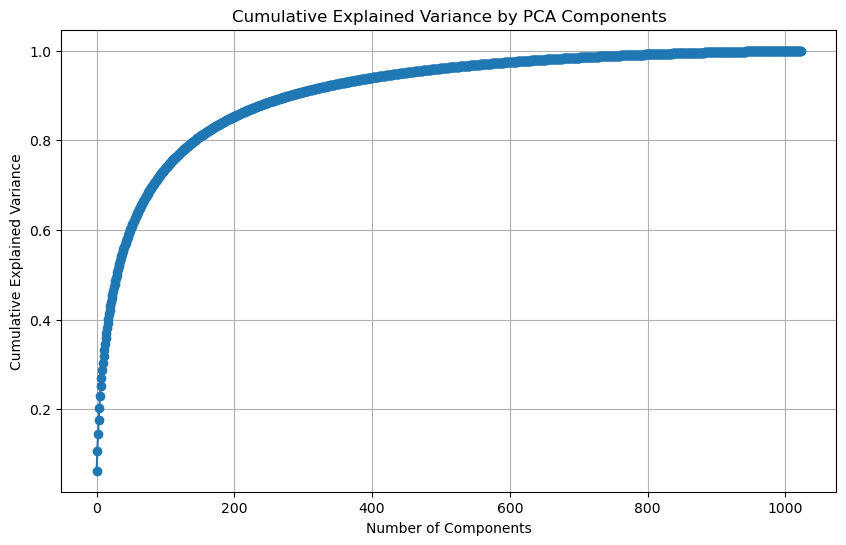

Number of components to retain 90% variance: 282
                                          embeddings  \
0  [0.0682, -0.04648, 0.001752, -0.00858, 0.00376...   
1  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
2  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
3  [0.002447, 0.007053, 0.06445, 0.00727, -0.0335...   
4  [0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...   

                                  reduced_embeddings  
0  [5.45236066566353, -5.875826457547928, 0.08367...  
1  [4.133830309065546, -1.0227187817030026, -7.10...  
2  [-4.523184764324939, -1.556923033197724, -3.69...  
3  [10.478726945204988, 1.9959073520378738, 9.146...  
4  [5.11267748050111, 5.149423237481653, 12.50653...  


In [34]:
# Extract embeddings and convert to NumPy array,
embeddings = np.array(combined_train['embeddings'].tolist())
# Standardize
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings)

# Apply PCA\n",
pca = PCA()
pca.fit(embeddings_standardized)

# Plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components to retain (in our case 90% of variance)
n_components = np.argmax(np.cumsum(explained_variance) >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA with chosen number of components
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings_standardized)

#Integrate reduced embeddings into combined_df
combined_train['reduced_embeddings'] = reduced_embeddings.tolist()
print(combined_train[['embeddings', 'reduced_embeddings']].head())

We'll see that considering each df separately doesn't change much.

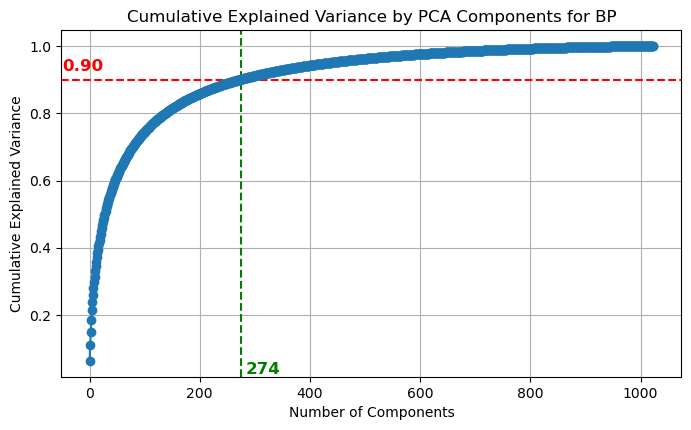

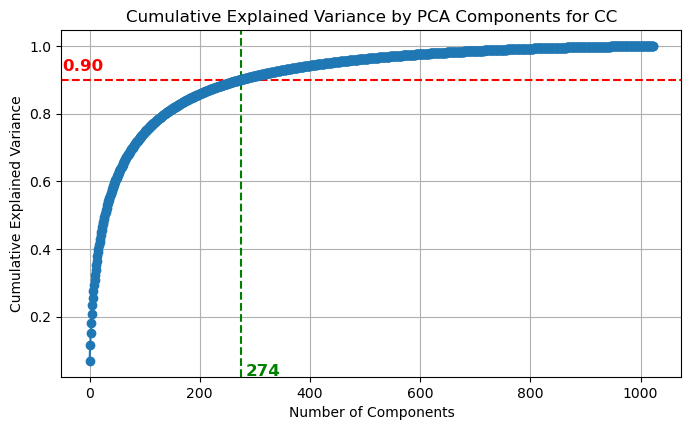

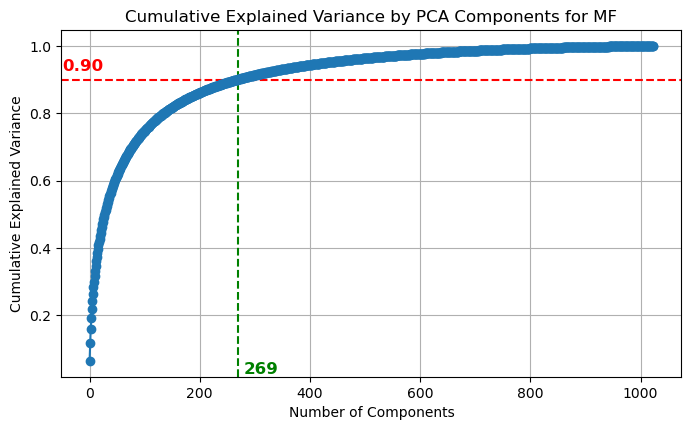

In [35]:
def pca_col(df, name, column_name='embeddings', variance_threshold=0.90):
    embeddings = np.array(df[column_name].tolist())
    
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(embeddings)
    
    pca = PCA()
    pca.fit(embeddings_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Components to retain (in our case 90% of variance)
    n_components = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
        
    plt.figure(figsize=(8, 4.5))
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    x_value = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
    plt.axvline(x=x_value, color='g', linestyle='--')
    plt.text(x_value + 10, 0.025, f'{x_value}', color='green', size='large', weight='bold')
    plt.text(- 50, variance_threshold + 0.025, f'{variance_threshold:.2f}', color='red', size='large', weight='bold')

    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title(f'Cumulative Explained Variance by PCA Components for {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_standardized)
    
    # Integrate reduced embeddings into the DataFrame
    df[f'reduced_{column_name}'] = reduced_embeddings.tolist()
    return df

# Apply PCA and add column for each dataset
x_df_BP = pca_col(x_df_BP, 'BP')
x_df_CC = pca_col(x_df_CC, 'CC')
x_df_MF = pca_col(x_df_MF, 'MF')

In [36]:
x_df_CC.columns.values

array(['ID', 'embeddings', 'sequence', 'ipr', 'domain', 'familyID',
       'start', 'end', 'reduced_embeddings'], dtype=object)

# MODELS

# CC (Elia)

In [65]:

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
# Load data
X = x_df_CC['embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame

# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_CC)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

## Models

In [110]:
# NN1

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048]    
output_size = y_train.shape[1]   

# Initialize the model
model1_cc = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model1_cc.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model1_cc, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model1_cc.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model1_cc.eval()
with torch.no_grad():
    y_pred = model1_cc(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0378
Epoch [2/75], Loss: 0.0318
Epoch [3/75], Loss: 0.0255
Epoch [4/75], Loss: 0.0234
Epoch [5/75], Loss: 0.0183
Epoch [6/75], Loss: 0.0110
Epoch [7/75], Loss: 0.0142
Epoch [8/75], Loss: 0.0086
Epoch [9/75], Loss: 0.0077
Epoch [10/75], Loss: 0.0095
Epoch [11/75], Loss: 0.0097
Epoch [12/75], Loss: 0.0162
Epoch [13/75], Loss: 0.0042
Epoch [14/75], Loss: 0.0056
Epoch [15/75], Loss: 0.0180
Epoch [16/75], Loss: 0.0076
Epoch [17/75], Loss: 0.0033
Epoch [18/75], Loss: 0.0032
Epoch [19/75], Loss: 0.0024
Epoch [20/75], Loss: 0.0139
Epoch [21/75], Loss: 0.0030
Epoch [22/75], Loss: 0.0138
Epoch [23/75], Loss: 0.0048
Epoch [24/75], Loss: 0.0016
Epoch [25/75], Loss: 0.0030
Epoch [26/75], Loss: 0.0124
Epoch [27/75], Loss: 0.0238
Epoch [28/75], Loss: 0.0133
Epoch [29/75], Loss: 0.0027
Epoch [30/75], Loss: 0.0032
Epoch [31/75], Loss: 0.0019
Epoch [32/75], Loss: 0.0011
Epoch [33/75], Loss: 0.0119
Epoch [34/75], Loss: 0.0441
Epoch [35/75], Loss: 0.0011
Epoch [36/75], Loss: 0.0110
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
# Print the model summary
_ = summary(model1_cc, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       4,198,400
              ReLU-2                 [-1, 4096]               0
           Dropout-3                 [-1, 4096]               0
            Linear-4                 [-1, 2048]       8,390,656
              ReLU-5                 [-1, 2048]               0
           Dropout-6                 [-1, 2048]               0
            Linear-7                  [-1, 839]       1,719,111
           Sigmoid-8                  [-1, 839]               0
Total params: 14,308,167
Trainable params: 14,308,167
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 54.58
Estimated Total Size (MB): 54.74
----------------------------------------------------------------


In [112]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model1_cc.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model1_cc(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.43      0.37      0.39        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.71      0.31      0.43        16
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.59      0.78      0.67        58
          12       0.50      0.70      0.58        27
          13       0.50      0.75      0.60        20
          14       0.56      0.89      0.69        27
          15       0.38      0.81      0.52        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       0.67      0.67      0.67         3
           4       0.46      0.36      0.41        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       0.73      0.50      0.59        16
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       0.50      1.00      0.67         1
          11       0.60      0.76      0.67        50
          12       0.36      0.40      0.38        20
          13       0.23      0.19      0.21        16
          14       0.46      0.62      0.53        21
          15       0.33      0.35      0.34        20
          16       0.00      0.00      0.00         2
          17       0.50    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         3
           3       0.80      0.67      0.73         6
           4       0.29      0.27      0.28        37
           5       0.00      0.00      0.00         1
           6       1.00      0.33      0.50         3
           7       0.58      0.54      0.56        13
           8       1.00      1.00      1.00         1
           9       1.00      0.50      0.67         2
          10       1.00      0.60      0.75         5
          11       0.62      0.71      0.66        68
          12       0.34      0.41      0.38        29
          13       0.32      0.40      0.36        20
          14       0.56      0.62      0.59        32
          15       0.41      0.62      0.49        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.75      0.43      0.55         7
           4       0.32      0.28      0.30        39
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         4
           7       0.33      0.14      0.20         7
           8       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       0.57      0.65      0.61        57
          12       0.28      0.40      0.33        20
          13       0.19      0.31      0.24        13
          14       0.42      0.74      0.54        23
          15       0.27      0.50      0.35        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      0.50      0.67         6
           4       0.39      0.28      0.33        47
           5       0.75      0.75      0.75         4
           6       0.00      0.00      0.00         3
           7       0.17      0.12      0.14         8
           8       0.25      0.50      0.33         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.52      0.79      0.63        42
          12       0.48      0.82      0.61        17
          13       0.30      0.54      0.39        13
          14       0.44      0.88      0.59        17
          15       0.33      0.79      0.47        14
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users


Fold 9/10
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.48      0.35      0.41        43
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         2
           7       0.57      0.33      0.42        12
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.62      0.71      0.67        49
          12       0.40      0.63      0.49        19
          13       0.30      0.50      0.38        14
          14       0.38      0.63      0.47        19
          15       0.33      0.50      0.40        20
          16       0.00      0.00      0.00         1
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

In [113]:
# NN2
 
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.1),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [4096, 2048]          
output_size = y_train.shape[1]   

# Initialize the model
model2_cc = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model2_cc.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model2_cc, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model2_cc.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model2_cc.eval()
with torch.no_grad():
    y_pred = model2_cc(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0428
Epoch [2/75], Loss: 0.0401
Epoch [3/75], Loss: 0.0374
Epoch [4/75], Loss: 0.0338
Epoch [5/75], Loss: 0.0311
Epoch [6/75], Loss: 0.0291
Epoch [7/75], Loss: 0.0279
Epoch [8/75], Loss: 0.0266
Epoch [9/75], Loss: 0.0256
Epoch [10/75], Loss: 0.0246
Epoch [11/75], Loss: 0.0238
Epoch [12/75], Loss: 0.0231
Epoch [13/75], Loss: 0.0225
Epoch [14/75], Loss: 0.0219
Epoch [15/75], Loss: 0.0214
Epoch [16/75], Loss: 0.0208
Epoch [17/75], Loss: 0.0203
Epoch [18/75], Loss: 0.0198
Epoch [19/75], Loss: 0.0194
Epoch [20/75], Loss: 0.0190
Epoch [21/75], Loss: 0.0186
Epoch [22/75], Loss: 0.0180
Epoch [23/75], Loss: 0.0176
Epoch [24/75], Loss: 0.0171
Epoch [25/75], Loss: 0.0168
Epoch [26/75], Loss: 0.0163
Epoch [27/75], Loss: 0.0160
Epoch [28/75], Loss: 0.0157
Epoch [29/75], Loss: 0.0153
Epoch [30/75], Loss: 0.0149
Epoch [31/75], Loss: 0.0146
Epoch [32/75], Loss: 0.0143
Epoch [33/75], Loss: 0.0138
Epoch [34/75], Loss: 0.0135
Epoch [35/75], Loss: 0.0132
Epoch [36/75], Loss: 0.0127
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model2_cc.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model2_cc(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users


Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.54      0.34      0.42        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      0.06      0.12        16
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.68      0.67      0.68        58
          12       0.35      0.22      0.27        27
          13       0.44      0.20      0.28        20
          14       0.52      0.44      0.48        27
          15       0.50      0.48      0.49        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       1.00      0.33      0.50         3
           4       0.56      0.32      0.41        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       0.83      0.31      0.45        16
           8       1.00      0.67      0.80         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.66      0.54      0.59        50
          12       0.42      0.25      0.31        20
          13       0.33      0.12      0.18        16
          14       0.60      0.43      0.50        21
          15       0.25      0.15      0.19        20
          16       0.00      0.00      0.00         2
          17       1.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         3
           3       0.75      0.50      0.60         6
           4       0.25      0.14      0.18        37
           5       0.00      0.00      0.00         1
           6       1.00      0.33      0.50         3
           7       0.83      0.38      0.53        13
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          10       1.00      0.40      0.57         5
          11       0.69      0.56      0.62        68
          12       0.38      0.31      0.34        29
          13       0.21      0.15      0.18        20
          14       0.46      0.34      0.39        32
          15       0.43      0.35      0.38        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.75      0.43      0.55         7
           4       0.44      0.28      0.34        39
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.50      0.14      0.22         7
           8       0.00      0.00      0.00         0
           9       0.50      1.00      0.67         1
          10       0.00      0.00      0.00         1
          11       0.65      0.60      0.62        57
          12       0.50      0.35      0.41        20
          13       0.40      0.15      0.22        13
          14       0.53      0.43      0.48        23
          15       0.38      0.28      0.32        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      0.50      0.67         6
           4       0.40      0.21      0.28        47
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         8
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.60      0.69      0.64        42
          12       0.43      0.35      0.39        17
          13       0.38      0.23      0.29        13
          14       0.60      0.53      0.56        17
          15       0.27      0.29      0.28        14
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [115]:
# NN3

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [2048, 1024]       
output_size = y_train.shape[1] 

# Initialize the model
model3_cc = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model3_cc.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 2048

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model3_cc, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model3_cc.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model3_cc.eval()
with torch.no_grad():
    y_pred = model3_cc(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0816
Epoch [2/75], Loss: 0.0452
Epoch [3/75], Loss: 0.0415
Epoch [4/75], Loss: 0.0410
Epoch [5/75], Loss: 0.0399
Epoch [6/75], Loss: 0.0383
Epoch [7/75], Loss: 0.0367
Epoch [8/75], Loss: 0.0349
Epoch [9/75], Loss: 0.0333
Epoch [10/75], Loss: 0.0321
Epoch [11/75], Loss: 0.0310
Epoch [12/75], Loss: 0.0301
Epoch [13/75], Loss: 0.0295
Epoch [14/75], Loss: 0.0289
Epoch [15/75], Loss: 0.0284
Epoch [16/75], Loss: 0.0278
Epoch [17/75], Loss: 0.0274
Epoch [18/75], Loss: 0.0269
Epoch [19/75], Loss: 0.0265
Epoch [20/75], Loss: 0.0262
Epoch [21/75], Loss: 0.0256
Epoch [22/75], Loss: 0.0254
Epoch [23/75], Loss: 0.0250
Epoch [24/75], Loss: 0.0248
Epoch [25/75], Loss: 0.0244
Epoch [26/75], Loss: 0.0241
Epoch [27/75], Loss: 0.0239
Epoch [28/75], Loss: 0.0237
Epoch [29/75], Loss: 0.0234
Epoch [30/75], Loss: 0.0233
Epoch [31/75], Loss: 0.0230
Epoch [32/75], Loss: 0.0228
Epoch [33/75], Loss: 0.0225
Epoch [34/75], Loss: 0.0223
Epoch [35/75], Loss: 0.0222
Epoch [36/75], Loss: 0.0218
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [116]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model3_cc.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model3_cc(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users


Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         3
           4       0.73      0.27      0.39        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      0.06      0.12        16
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       0.68      0.59      0.63        58
          12       0.50      0.15      0.23        27
          13       0.50      0.15      0.23        20
          14       0.48      0.37      0.42        27
          15       0.56      0.24      0.33        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         3
           4       0.71      0.27      0.39        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       0.83      0.31      0.45        16
           8       1.00      0.67      0.80         3
           9       1.00      0.33      0.50         3
          10       0.00      0.00      0.00         1
          11       0.59      0.44      0.51        50
          12       0.33      0.05      0.09        20
          13       0.00      0.00      0.00        16
          14       0.54      0.33      0.41        21
          15       0.20      0.05      0.08        20
          16       0.00      0.00      0.00         2
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         6
           4       0.43      0.16      0.24        37
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00        13
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         5
          11       0.56      0.49      0.52        68
          12       0.14      0.03      0.06        29
          13       0.17      0.05      0.08        20
          14       0.60      0.47      0.53        32
          15       0.22      0.08      0.11        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       1.00      0.29      0.44         7
           4       0.50      0.18      0.26        39
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.63      0.60      0.61        57
          12       0.60      0.15      0.24        20
          13       0.33      0.08      0.12        13
          14       0.56      0.43      0.49        23
          15       0.67      0.22      0.33        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           3       1.00      0.25      0.40         4
           4       0.67      0.23      0.34        43
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       1.00      0.08      0.15        12
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.68      0.65      0.67        49
          12       0.75      0.16      0.26        19
          13       0.00      0.00      0.00        14
          14       0.45      0.47      0.46        19
          15       0.57      0.20      0.30        20
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [117]:
# NN4

class ImprovedMultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ImprovedMultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [2048, 1024]          
output_size = y_train.shape[1]  

# Initialize the model
model4_cc = ImprovedMultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()

# Optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model4_cc.parameters(), lr=0.005, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, scheduler, batch_size, epochs):
    model.train()

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Train the model
train_model(model4_cc, X_train_tensor, y_train_tensor, optimizer, criterion, scheduler, batch_size, epochs)

# Evaluation
model4_cc.eval()
with torch.no_grad():
    y_pred = model4_cc(X_test_tensor)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)

# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nImproved Neural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 3.0620
Epoch [2/75], Loss: 1.4212
Epoch [3/75], Loss: 1.2099
Epoch [4/75], Loss: 1.1051
Epoch [5/75], Loss: 1.0576
Epoch [6/75], Loss: 0.9916
Epoch [7/75], Loss: 0.9651
Epoch [8/75], Loss: 0.9478
Epoch [9/75], Loss: 0.9314
Epoch [10/75], Loss: 0.9193
Epoch [11/75], Loss: 0.8681
Epoch [12/75], Loss: 0.8395
Epoch [13/75], Loss: 0.8260
Epoch [14/75], Loss: 0.8134
Epoch [15/75], Loss: 0.8034
Epoch [16/75], Loss: 0.7550
Epoch [17/75], Loss: 0.7216
Epoch [18/75], Loss: 0.7043
Epoch [19/75], Loss: 0.6936
Epoch [20/75], Loss: 0.6818
Epoch [21/75], Loss: 0.6432
Epoch [22/75], Loss: 0.6176
Epoch [23/75], Loss: 0.5999
Epoch [24/75], Loss: 0.5895
Epoch [25/75], Loss: 0.5788
Epoch [26/75], Loss: 0.5522
Epoch [27/75], Loss: 0.5353
Epoch [28/75], Loss: 0.5257
Epoch [29/75], Loss: 0.5159
Epoch [30/75], Loss: 0.5083
Epoch [31/75], Loss: 0.4914
Epoch [32/75], Loss: 0.4832
Epoch [33/75], Loss: 0.4759
Epoch [34/75], Loss: 0.4695
Epoch [35/75], Loss: 0.4646
Epoch [36/75], Loss: 0.4554
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [118]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model4_cc.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model4_cc(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users


Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         3
           4       0.57      0.41      0.48        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      0.06      0.12        16
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       0.66      0.67      0.67        58
          12       0.61      0.52      0.56        27
          13       0.67      0.50      0.57        20
          14       0.62      0.67      0.64        27
          15       0.59      0.62      0.60        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.53      0.41      0.46        44
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         0
           7       0.62      0.31      0.42        16
           8       1.00      0.67      0.80         3
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.72      0.56      0.63        50
          12       0.23      0.15      0.18        20
          13       0.14      0.06      0.09        16
          14       0.55      0.52      0.54        21
          15       0.11      0.05      0.07        20
          16       0.00      0.00      0.00         2
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         1
           2       1.00      0.33      0.50         3
           3       0.67      0.33      0.44         6
           4       0.36      0.32      0.34        37
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.50      0.31      0.38        13
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         5
          11       0.67      0.54      0.60        68
          12       0.39      0.31      0.35        29
          13       0.27      0.20      0.23        20
          14       0.42      0.34      0.38        32
          15       0.37      0.27      0.31        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       1.00      0.43      0.60         7
           4       0.34      0.28      0.31        39
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       1.00      0.14      0.25         7
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.59      0.61      0.60        57
          12       0.35      0.35      0.35        20
          13       0.33      0.23      0.27        13
          14       0.46      0.48      0.47        23
          15       0.42      0.28      0.33        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         6
           4       0.45      0.32      0.38        47
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.60      0.69      0.64        42
          12       0.39      0.41      0.40        17
          13       0.40      0.31      0.35        13
          14       0.54      0.76      0.63        17
          15       0.36      0.36      0.36        14
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

In [119]:
# NN5

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048, 1024]    
output_size = y_train.shape[1]   

# Initialize the model
model5_cc = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model5_cc.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model5_cc, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model5_cc.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model5_cc.eval()
with torch.no_grad():
    y_pred = model5_cc(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 0.0435
Epoch [2/75], Loss: 0.0320
Epoch [3/75], Loss: 0.0323
Epoch [4/75], Loss: 0.0288
Epoch [5/75], Loss: 0.0251
Epoch [6/75], Loss: 0.0214
Epoch [7/75], Loss: 0.0215
Epoch [8/75], Loss: 0.0198
Epoch [9/75], Loss: 0.0180
Epoch [10/75], Loss: 0.0147
Epoch [11/75], Loss: 0.0143
Epoch [12/75], Loss: 0.0148
Epoch [13/75], Loss: 0.0150
Epoch [14/75], Loss: 0.0094
Epoch [15/75], Loss: 0.0113
Epoch [16/75], Loss: 0.0070
Epoch [17/75], Loss: 0.0090
Epoch [18/75], Loss: 0.0068
Epoch [19/75], Loss: 0.0058
Epoch [20/75], Loss: 0.0049
Epoch [21/75], Loss: 0.0062
Epoch [22/75], Loss: 0.0046
Epoch [23/75], Loss: 0.0041
Epoch [24/75], Loss: 0.0051
Epoch [25/75], Loss: 0.0047
Epoch [26/75], Loss: 0.0068
Epoch [27/75], Loss: 0.0094
Epoch [28/75], Loss: 0.0111
Epoch [29/75], Loss: 0.0036
Epoch [30/75], Loss: 0.0033
Epoch [31/75], Loss: 0.0047
Epoch [32/75], Loss: 0.0025
Epoch [33/75], Loss: 0.0081
Epoch [34/75], Loss: 0.0041
Epoch [35/75], Loss: 0.0027
Epoch [36/75], Loss: 0.0023
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [120]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model5_cc.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model5_cc(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users


Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.47      0.34      0.39        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      0.12      0.22        16
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         1
          10       0.33      1.00      0.50         1
          11       0.68      0.69      0.68        58
          12       0.48      0.52      0.50        27
          13       0.71      0.50      0.59        20
          14       0.56      0.56      0.56        27
          15       0.52      0.52      0.52        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         3
           4       0.52      0.32      0.39        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       1.00      0.31      0.48        16
           8       1.00      1.00      1.00         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.65      0.66      0.65        50
          12       0.20      0.15      0.17        20
          13       0.00      0.00      0.00        16
          14       0.48      0.48      0.48        21
          15       0.00      0.00      0.00        20
          16       0.00      0.00      0.00         2
          17       1.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         3
           3       0.60      0.50      0.55         6
           4       0.27      0.22      0.24        37
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.62      0.38      0.48        13
           8       0.50      1.00      0.67         1
           9       1.00      0.50      0.67         2
          10       1.00      0.60      0.75         5
          11       0.65      0.50      0.57        68
          12       0.43      0.31      0.36        29
          13       0.21      0.15      0.18        20
          14       0.58      0.56      0.57        32
          15       0.31      0.19      0.24        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       1.00      0.43      0.60         7
           4       0.30      0.26      0.28        39
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       1.00      0.14      0.25         7
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.63      0.60      0.61        57
          12       0.33      0.35      0.34        20
          13       0.30      0.23      0.26        13
          14       0.48      0.48      0.48        23
          15       0.58      0.39      0.47        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      0.17      0.29         6
           4       0.55      0.36      0.44        47
           5       1.00      0.75      0.86         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         8
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.53      0.60      0.56        42
          12       0.29      0.29      0.29        17
          13       0.25      0.23      0.24        13
          14       0.48      0.59      0.53        17
          15       0.23      0.21      0.22        14
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


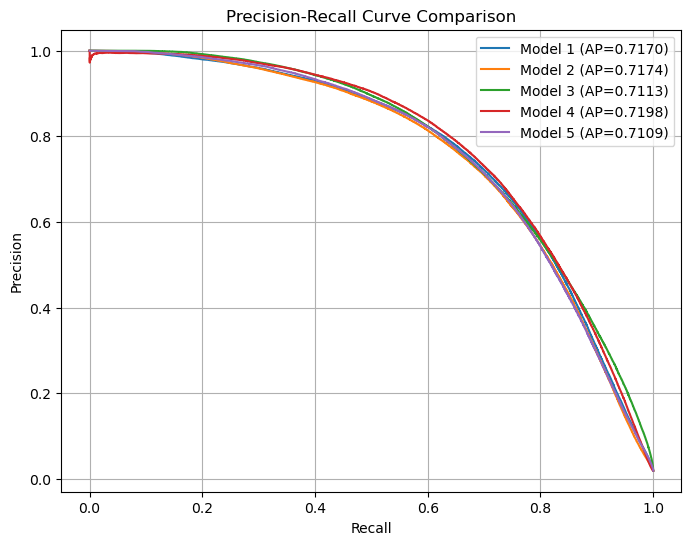

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curves(models, X_test_tensor, y_test, device):
    plt.figure(figsize=(8, 6))
    
    for model_name, model in models.items():
        with torch.no_grad():
            y_pred = model(X_test_tensor.to(device))
            y_pred_prob = y_pred.cpu().numpy()
        
        # Compute micro-average precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_prob.ravel())
        avg_precision = average_precision_score(y_test, y_pred_prob, average="weighted")
        
        plt.plot(recall, precision, label=f'{model_name} (AP={avg_precision:.4f})')
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Dictionary containing models
models = {
    "Model 1": model1_cc,
    "Model 2": model2_cc,
    "Model 3": model3_cc,
    "Model 4": model4_cc,
    "Model 5": model5_cc,
}

# Call the function to plot
plot_precision_recall_curves(models, X_test_tensor, y_test, device)


## Comparison of Neural Network Models

In this section, we compare the parameters and results of the five neural network models (NN 1, NN 2, NN 3, NN 4, and NN 5) used in our analysis.

### Model Parameters

| Model | Hidden Layer Sizes | Dropout Rates | Learning Rate | Batch Size | Epochs | Regularization |
|-------|---------------------|---------------|---------------|------------|--------|----------------|
| NN 1  | [4096, 2048]        | [0.3, 0.3]    | 0.005         | 512        | 75     | None           |
| NN 2  | [4096, 2048]        | [0.1, 0.1]    | 0.001         | 1024       | 75     | None           |
| NN 3  | [2048, 1024]        | [0.2, 0.2]    | 0.001         | 2048       | 75     | None           |
| NN 4  | [2048, 1024]        | [0.2, 0.3]    | 0.005         | 1024       | 75     | L2 (weight decay=1e-5) |
| NN 5  | [4096, 2048, 1024]  | [0.2, 0.2, 0.2]| 0.005         | 512        | 75     | None           |

### Model Results

| Model | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score | Samples Avg Precision | Samples Avg Recall | Samples Avg F1-Score | Training Time |
|-------|----------------------|------------------|---------------------|------------------------|---------------------|------------------------|-----------------------|---------------------|----------------------|---------------|
| NN 1  | 0.48                 | 0.34             | 0.38                | 0.72                   | 0.68                | 0.69                   | 0.78                  | 0.74                | 0.72                 | 70 min        |
| NN 2  | 0.54                 | 0.30             | 0.36                | 0.75                   | 0.63                | 0.67                   | 0.81                  | 0.70                | 0.71                 | 30 min        |
| NN 3  | 0.46                 | 0.17             | 0.22                | 0.74                   | 0.62                | 0.65                   | 0.82                  | 0.69                | 0.71                 | 10 min        |
| NN 4  | 0.41                 | 0.17             | 0.22                | 0.74                   | 0.64                | 0.67                   | 0.82                  | 0.71                | 0.72                 | 10 min        |
| NN 5  | 0.53                 | 0.27             | 0.33                | 0.74                   | 0.65                | 0.68                   | 0.80                  | 0.72                | 0.72                 | 90 min        |

### Observations

- **NN 1**: Achieved a balanced performance with a macro average F1-score of 0.38 and a weighted average F1-score of 0.69. The training time was the longest at 70 minutes.
- **NN 2**: Improved precision but lower recall compared to NN 1. The training time was reduced to 30 minutes.
- **NN 3**: Reduced hidden layer sizes and increased batch size resulted in a significant reduction in training time to 10 minutes, but the macro average F1-score dropped to 0.22.
- **NN 4**: Introduced batch normalization and L2 regularization. The performance was similar to NN 3, with a macro average F1-score of 0.22 and a weighted average F1-score of 0.67. The training time remained at 10 minutes.
- **NN 5**: Added an additional hidden layer and maintained dropout rates. Achieved a macro average F1-score of 0.33 and a weighted average F1-score of 0.68. The training time was 90 minutes.

Overall, **NN 1** provided the best balance between precision, recall, and F1-score, although it had the longest training time. **NN 2** offered a good trade-off between performance and training time. **NN 3** and **NN 4** had the shortest training times but lower macro average F1-scores. **NN 5** showed competitive performance with a slightly longer training time.

**Best result**: NN1
|   | Avg Precision | Avg Recall | Avg F1-Score |
|---|---|---|---|
| *Weighted*  | 0.72 | 0.68 | 0.69 |
| *Macro*  | 0.48 | 0.34 | 0.38 |

# MF (Vale)

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
# Load data
X = x_df_MF['embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame


# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_MF)

# Split data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:

np_array = X_train_full.to_numpy()
np_array_test = X_test_full.to_numpy()

# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(np_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device) 
X_test_tensor = torch.tensor(np_array_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [83]:
# NN 1

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [4096, 2048]    # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model1_mf = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model1_mf.parameters(), lr=0.001)

# Training loop
epochs = 50
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model1_mf, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model1_mf.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model1_mf.eval()
with torch.no_grad():
    y_pred = model1_mf(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))



Epoch [1/50], Loss: 0.0428
Epoch [2/50], Loss: 0.0342
Epoch [3/50], Loss: 0.0305
Epoch [4/50], Loss: 0.0274
Epoch [5/50], Loss: 0.0246
Epoch [6/50], Loss: 0.0191
Epoch [7/50], Loss: 0.0162
Epoch [8/50], Loss: 0.0139
Epoch [9/50], Loss: 0.0111
Epoch [10/50], Loss: 0.0103
Epoch [11/50], Loss: 0.0087
Epoch [12/50], Loss: 0.0082
Epoch [13/50], Loss: 0.0071
Epoch [14/50], Loss: 0.0060
Epoch [15/50], Loss: 0.0055
Epoch [16/50], Loss: 0.0046
Epoch [17/50], Loss: 0.0049
Epoch [18/50], Loss: 0.0041
Epoch [19/50], Loss: 0.0041
Epoch [20/50], Loss: 0.0039
Epoch [21/50], Loss: 0.0036
Epoch [22/50], Loss: 0.0032
Epoch [23/50], Loss: 0.0027
Epoch [24/50], Loss: 0.0041
Epoch [25/50], Loss: 0.0029
Epoch [26/50], Loss: 0.0034
Epoch [27/50], Loss: 0.0027
Epoch [28/50], Loss: 0.0026
Epoch [29/50], Loss: 0.0022
Epoch [30/50], Loss: 0.0022
Epoch [31/50], Loss: 0.0020
Epoch [32/50], Loss: 0.0019
Epoch [33/50], Loss: 0.0023
Epoch [34/50], Loss: 0.0016
Epoch [35/50], Loss: 0.0018
Epoch [36/50], Loss: 0.0015
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model1_mf.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model1_mf(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")



Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.48      0.32      0.38        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.67      0.12      0.21        16
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.59      0.55      0.57        58
          12       0.55      0.41      0.47        27
          13       0.57      0.40      0.47        20
          14       0.61      0.41      0.49        27
          15       0.62      0.48      0.54        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       0.50      0.33      0.40         3
           4       0.54      0.30      0.38        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       1.00      0.38      0.55        16
           8       1.00      0.67      0.80         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.76      0.58      0.66        50
          12       0.11      0.05      0.07        20
          13       0.00      0.00      0.00        16
          14       0.43      0.14      0.21        21
          15       0.20      0.10      0.13        20
          16       0.00      0.00      0.00         2
          17       1.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.33      0.20      0.25         5
           4       0.45      0.38      0.41        37
           5       0.00      0.00      0.00         1
           6       0.50      0.50      0.50         2
           7       0.67      0.25      0.36        16
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1
          11       0.61      0.41      0.49        56
          12       0.50      0.19      0.28        31
          13       0.40      0.17      0.24        24
          14       0.46      0.17      0.24        36
          15       0.54      0.27      0.36        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       0.50      1.00      0.67         1
           4       0.48      0.26      0.33        47
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         2
           7       1.00      0.13      0.24        15
           8       0.00      0.00      0.00         1
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.72      0.48      0.58        75
          12       0.55      0.29      0.38        41
          13       0.29      0.13      0.18        30
          14       0.60      0.38      0.47        39
          15       0.24      0.11      0.15        35
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

In [85]:
# NN 2
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [4096, 4096]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model2_mf = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model2_mf.parameters(), lr=0.001)

# Training loop
epochs = 100
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model2_mf, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model2_mf.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model2_mf.eval()
with torch.no_grad():
    y_pred = model2_mf(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/100], Loss: 0.0406
Epoch [2/100], Loss: 0.0335
Epoch [3/100], Loss: 0.0301
Epoch [4/100], Loss: 0.0259
Epoch [5/100], Loss: 0.0226
Epoch [6/100], Loss: 0.0197
Epoch [7/100], Loss: 0.0156
Epoch [8/100], Loss: 0.0121
Epoch [9/100], Loss: 0.0095
Epoch [10/100], Loss: 0.0094
Epoch [11/100], Loss: 0.0077
Epoch [12/100], Loss: 0.0065
Epoch [13/100], Loss: 0.0095
Epoch [14/100], Loss: 0.0072
Epoch [15/100], Loss: 0.0060
Epoch [16/100], Loss: 0.0043
Epoch [17/100], Loss: 0.0045
Epoch [18/100], Loss: 0.0054
Epoch [19/100], Loss: 0.0032
Epoch [20/100], Loss: 0.0056
Epoch [21/100], Loss: 0.0045
Epoch [22/100], Loss: 0.0034
Epoch [23/100], Loss: 0.0024
Epoch [24/100], Loss: 0.0029
Epoch [25/100], Loss: 0.0026
Epoch [26/100], Loss: 0.0024
Epoch [27/100], Loss: 0.0022
Epoch [28/100], Loss: 0.0023
Epoch [29/100], Loss: 0.0022
Epoch [30/100], Loss: 0.0022
Epoch [31/100], Loss: 0.0014
Epoch [32/100], Loss: 0.0020
Epoch [33/100], Loss: 0.0018
Epoch [34/100], Loss: 0.0019
Epoch [35/100], Loss: 0

In [102]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]
    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model2_mf.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model2_mf(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")



Fold 1/10


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.47      0.41      0.44        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.62      0.31      0.42        16
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.63      0.72      0.67        58
          12       0.48      0.59      0.53        27
          13       0.50      0.65      0.57        20
          14       0.59      0.74      0.66        27
          15       0.48      0.76      0.59        21
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       0.67      0.67      0.67         3
           4       0.38      0.41      0.40        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       0.60      0.38      0.46        16
           8       1.00      0.33      0.50         3
           9       1.00      0.67      0.80         3
          10       0.50      1.00      0.67         1
          11       0.63      0.62      0.63        50
          12       0.38      0.40      0.39        20
          13       0.15      0.12      0.14        16
          14       0.54      0.62      0.58        21
          15       0.23      0.15      0.18        20
          16       0.50      0.50      0.50         2
          17       0.40    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         4
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1
           4       0.56      0.40      0.47        35
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         3
           7       0.57      0.31      0.40        13
           8       0.00      0.00      0.00         0
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         1
          11       0.50      0.50      0.50        38
          12       0.44      0.35      0.39        20
          13       0.42      0.38      0.40        13
          14       0.35      0.47      0.40        19
          15       0.31      0.38      0.34        13
          16       0.50      0.33      0.40         3
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.40      0.40      0.40         5
           4       0.31      0.41      0.35        37
           5       0.33      1.00      0.50         1
           6       1.00      0.50      0.67         2
           7       0.62      0.31      0.42        16
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          10       0.50      1.00      0.67         1
          11       0.62      0.59      0.61        56
          12       0.38      0.35      0.37        31
          13       0.41      0.38      0.39        24
          14       0.56      0.64      0.60        36
          15       0.44      0.46      0.45        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       0.20      1.00      0.33         1
           4       0.44      0.36      0.40        47
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         2
           7       0.67      0.13      0.22        15
           8       0.00      0.00      0.00         1
           9       1.00      0.33      0.50         3
          10       0.50      1.00      0.67         1
          11       0.68      0.65      0.67        75
          12       0.56      0.56      0.56        41
          13       0.48      0.43      0.46        30
          14       0.57      0.69      0.63        39
          15       0.44      0.40      0.42        35
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

In [87]:
# NN 3
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [4096, 2048]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model3_mf = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model3_mf.parameters(), lr=0.001)

# Training loop
epochs = 110
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model3_mf, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model3_mf.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model3_mf.eval()
with torch.no_grad():
    y_pred = model3_mf(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/110], Loss: 0.0428
Epoch [2/110], Loss: 0.0403
Epoch [3/110], Loss: 0.0374
Epoch [4/110], Loss: 0.0343
Epoch [5/110], Loss: 0.0315
Epoch [6/110], Loss: 0.0298
Epoch [7/110], Loss: 0.0282
Epoch [8/110], Loss: 0.0272
Epoch [9/110], Loss: 0.0261
Epoch [10/110], Loss: 0.0253
Epoch [11/110], Loss: 0.0243
Epoch [12/110], Loss: 0.0240
Epoch [13/110], Loss: 0.0232
Epoch [14/110], Loss: 0.0225
Epoch [15/110], Loss: 0.0219
Epoch [16/110], Loss: 0.0213
Epoch [17/110], Loss: 0.0209
Epoch [18/110], Loss: 0.0206
Epoch [19/110], Loss: 0.0200
Epoch [20/110], Loss: 0.0196
Epoch [21/110], Loss: 0.0191
Epoch [22/110], Loss: 0.0189
Epoch [23/110], Loss: 0.0186
Epoch [24/110], Loss: 0.0180
Epoch [25/110], Loss: 0.0178
Epoch [26/110], Loss: 0.0172
Epoch [27/110], Loss: 0.0170
Epoch [28/110], Loss: 0.0166
Epoch [29/110], Loss: 0.0163
Epoch [30/110], Loss: 0.0159
Epoch [31/110], Loss: 0.0157
Epoch [32/110], Loss: 0.0153
Epoch [33/110], Loss: 0.0150
Epoch [34/110], Loss: 0.0147
Epoch [35/110], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [101]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model3_mf.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model3_mf(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")



Fold 1/10
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.38      0.49      0.43        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.44      0.44      0.44        16
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.67      0.62      0.64        58
          12       0.56      0.37      0.44        27
          13       0.64      0.35      0.45        20
          14       0.61      0.70      0.66        27
          15       0.56      0.43      0.49        21
          16       0.00      0.00      0.00         0
          17    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       1.00      0.33      0.50         3
           4       0.40      0.48      0.44        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       0.47      0.56      0.51        16
           8       1.00      0.67      0.80         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.68      0.60      0.64        50
          12       0.42      0.25      0.31        20
          13       0.50      0.19      0.27        16
          14       0.57      0.57      0.57        21
          15       0.50      0.20      0.29        20
          16       0.00      0.00      0.00         2
          17       0.50    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         3
           3       0.75      0.50      0.60         6
           4       0.30      0.51      0.38        37
           5       0.00      0.00      0.00         1
           6       1.00      0.33      0.50         3
           7       0.47      0.54      0.50        13
           8       1.00      1.00      1.00         1
           9       1.00      0.50      0.67         2
          10       1.00      0.60      0.75         5
          11       0.66      0.59      0.62        68
          12       0.33      0.21      0.26        29
          13       0.17      0.10      0.12        20
          14       0.54      0.47      0.50        32
          15       0.33      0.19      0.24        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.75      0.43      0.55         7
           4       0.33      0.51      0.40        39
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         4
           7       0.25      0.29      0.27         7
           8       0.00      0.00      0.00         0
           9       0.50      1.00      0.67         1
          10       0.00      0.00      0.00         1
          11       0.60      0.61      0.61        57
          12       0.42      0.40      0.41        20
          13       0.36      0.31      0.33        13
          14       0.48      0.57      0.52        23
          15       0.50      0.33      0.40        18
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      0.33      0.50         6
           4       0.37      0.47      0.42        47
           5       1.00      0.75      0.86         4
           6       0.00      0.00      0.00         3
           7       0.20      0.25      0.22         8
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.58      0.71      0.64        42
          12       0.44      0.41      0.42        17
          13       0.36      0.31      0.33        13
          14       0.63      0.71      0.67        17
          15       0.24      0.29      0.26        14
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         4
           2       0.80      0.80      0.80         5
           3       1.00      0.50      0.67         2
           4       0.43      0.57      0.49        35
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       0.45      0.33      0.38        15
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         2
          10       0.00      0.00      0.00         1
          11       0.55      0.55      0.55        47
          12       0.24      0.16      0.19        25
          13       0.00      0.00      0.00        16
          14       0.61      0.45      0.52        31
          15       0.31      0.20      0.24        20
          16       0.00      0.00      0.00         1
          17       0.00    

In [89]:
# NN 4
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [4096, 4096]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model4_mf = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model4_mf.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)


# Training loop
epochs = 150
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model4_mf, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model4_mf.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model4_mf.eval()
with torch.no_grad():
    y_pred = model4_mf(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/150], Loss: 0.0426
Epoch [2/150], Loss: 0.0400
Epoch [3/150], Loss: 0.0372
Epoch [4/150], Loss: 0.0337
Epoch [5/150], Loss: 0.0313
Epoch [6/150], Loss: 0.0294
Epoch [7/150], Loss: 0.0281
Epoch [8/150], Loss: 0.0268
Epoch [9/150], Loss: 0.0261
Epoch [10/150], Loss: 0.0251
Epoch [11/150], Loss: 0.0242
Epoch [12/150], Loss: 0.0235
Epoch [13/150], Loss: 0.0228
Epoch [14/150], Loss: 0.0222
Epoch [15/150], Loss: 0.0216
Epoch [16/150], Loss: 0.0208
Epoch [17/150], Loss: 0.0208
Epoch [18/150], Loss: 0.0199
Epoch [19/150], Loss: 0.0198
Epoch [20/150], Loss: 0.0190
Epoch [21/150], Loss: 0.0186
Epoch [22/150], Loss: 0.0183
Epoch [23/150], Loss: 0.0180
Epoch [24/150], Loss: 0.0177
Epoch [25/150], Loss: 0.0174
Epoch [26/150], Loss: 0.0171
Epoch [27/150], Loss: 0.0171
Epoch [28/150], Loss: 0.0165
Epoch [29/150], Loss: 0.0165
Epoch [30/150], Loss: 0.0161
Epoch [31/150], Loss: 0.0160
Epoch [32/150], Loss: 0.0155
Epoch [33/150], Loss: 0.0154
Epoch [34/150], Loss: 0.0151
Epoch [35/150], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]
    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model4_mf.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model4_mf(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")



Fold 1/10


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.58      0.37      0.45        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       1.00      0.19      0.32        16
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       0.69      0.66      0.67        58
          12       0.50      0.33      0.40        27
          13       0.64      0.45      0.53        20
          14       0.50      0.52      0.51        27
          15       0.62      0.48      0.54        21
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1
           3       1.00      0.33      0.50         3
           4       0.50      0.36      0.42        44
           5       1.00      0.50      0.67         4
           6       0.00      0.00      0.00         0
           7       1.00      0.31      0.48        16
           8       1.00      0.67      0.80         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.65      0.52      0.58        50
          12       0.33      0.15      0.21        20
          13       0.00      0.00      0.00        16
          14       0.58      0.52      0.55        21
          15       0.40      0.10      0.16        20
          16       0.00      0.00      0.00         2
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         4
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1
           4       0.65      0.37      0.47        35
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         3
           7       0.60      0.23      0.33        13
           8       0.00      0.00      0.00         0
           9       1.00      0.50      0.67         2
          10       0.00      0.00      0.00         1
          11       0.54      0.50      0.52        38
          12       0.40      0.30      0.34        20
          13       0.33      0.08      0.12        13
          14       0.42      0.42      0.42        19
          15       0.33      0.08      0.12        13
          16       1.00      0.33      0.50         3
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.33      0.20      0.25         5
           4       0.44      0.43      0.44        37
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.75      0.19      0.30        16
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1
          11       0.64      0.50      0.56        56
          12       0.47      0.23      0.30        31
          13       0.43      0.12      0.19        24
          14       0.62      0.42      0.50        36
          15       0.56      0.19      0.29        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       0.50      1.00      0.67         1
           4       0.47      0.34      0.40        47
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         2
           7       1.00      0.13      0.24        15
           8       0.00      0.00      0.00         1
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.75      0.55      0.63        75
          12       0.55      0.39      0.46        41
          13       0.30      0.10      0.15        30
          14       0.55      0.56      0.56        39
          15       0.35      0.17      0.23        35
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.55      0.28      0.37        43
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.50      0.17      0.25        12
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.71      0.65      0.68        49
          12       0.47      0.37      0.41        19
          13       0.71      0.36      0.48        14
          14       0.46      0.63      0.53        19
          15       0.58      0.35      0.44        20
          16       0.00      0.00      0.00         1
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

In [91]:
# NN 5

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [8192, 4096, 2048]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model5_mf = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model5_mf.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.6)


# Training loop
epochs = 100
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model5_mf, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model5_mf.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model5_mf.eval()
with torch.no_grad():
    y_pred = model5_mf(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/100], Loss: 0.0433
Epoch [2/100], Loss: 0.0393
Epoch [3/100], Loss: 0.0358
Epoch [4/100], Loss: 0.0316
Epoch [5/100], Loss: 0.0293
Epoch [6/100], Loss: 0.0262
Epoch [7/100], Loss: 0.0231
Epoch [8/100], Loss: 0.0194
Epoch [9/100], Loss: 0.0194
Epoch [10/100], Loss: 0.0159
Epoch [11/100], Loss: 0.0146
Epoch [12/100], Loss: 0.0112
Epoch [13/100], Loss: 0.0107
Epoch [14/100], Loss: 0.0097
Epoch [15/100], Loss: 0.0075
Epoch [16/100], Loss: 0.0080
Epoch [17/100], Loss: 0.0075
Epoch [18/100], Loss: 0.0052
Epoch [19/100], Loss: 0.0050
Epoch [20/100], Loss: 0.0056
Epoch [21/100], Loss: 0.0043
Epoch [22/100], Loss: 0.0052
Epoch [23/100], Loss: 0.0051
Epoch [24/100], Loss: 0.0035
Epoch [25/100], Loss: 0.0034
Epoch [26/100], Loss: 0.0071
Epoch [27/100], Loss: 0.0028
Epoch [28/100], Loss: 0.0032
Epoch [29/100], Loss: 0.0020
Epoch [30/100], Loss: 0.0019
Epoch [31/100], Loss: 0.0017
Epoch [32/100], Loss: 0.0021
Epoch [33/100], Loss: 0.0025
Epoch [34/100], Loss: 0.0013
Epoch [35/100], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [98]:
#10fold
from sklearn.model_selection import KFold


# Initialize your pre-trained model (already trained elsewhere)
# Assuming `model2_mf` is your pre-trained model that you've already trained.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_reports = []

# Model hyperparameters
batch_size = 512
epochs = 100  # Keeping consistent with your model settings

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_test_tensor)):
    print(f"\nFold {fold+1}/10")

    # Split data
    X_train, X_val = X_test_tensor[train_idx], X_test_tensor[val_idx]
    y_train, y_val = y_test_tensor[train_idx], y_test_tensor[val_idx]

    # Move validation labels to device
    y_val = y_val.to(device)

    # Set the model to evaluation mode
    model5_mf.eval()

    # Evaluate model on the validation set (no training involved)
    with torch.no_grad():
        y_pred = model5_mf(X_val.to(device)).cpu().numpy()
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Move y_val to CPU before converting to NumPy
    report = classification_report(y_val.cpu().numpy(), y_pred_binary, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val.cpu().numpy(), y_pred_binary))

# Aggregate classification results
avg_precision = np.mean([rep["macro avg"]["precision"] for rep in all_reports])
avg_recall = np.mean([rep["macro avg"]["recall"] for rep in all_reports])
avg_f1 = np.mean([rep["macro avg"]["f1-score"] for rep in all_reports])

print(f"\nFinal 10-Fold Results:\nPrecision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")



Fold 1/10


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       0.53      0.41      0.47        41
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.54      0.44      0.48        16
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.67      0.71      0.69        58
          12       0.50      0.44      0.47        27
          13       0.61      0.55      0.58        20
          14       0.62      0.59      0.60        27
          15       0.55      0.57      0.56        21
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         4
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       0.57      0.37      0.45        35
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         3
           7       0.50      0.23      0.32        13
           8       0.00      0.00      0.00         0
           9       1.00      0.50      0.67         2
          10       0.00      0.00      0.00         1
          11       0.58      0.55      0.57        38
          12       0.56      0.45      0.50        20
          13       0.50      0.31      0.38        13
          14       0.41      0.47      0.44        19
          15       0.33      0.23      0.27        13
          16       1.00      0.33      0.50         3
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.67      0.40      0.50         5
           4       0.34      0.41      0.37        37
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.55      0.38      0.44        16
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1
          11       0.62      0.52      0.56        56
          12       0.42      0.26      0.32        31
          13       0.43      0.25      0.32        24
          14       0.56      0.53      0.54        36
          15       0.42      0.31      0.36        26
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       0.50      1.00      0.67         1
           4       0.48      0.34      0.40        47
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         2
           7       0.40      0.13      0.20        15
           8       0.00      0.00      0.00         1
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         1
          11       0.71      0.59      0.64        75
          12       0.59      0.39      0.47        41
          13       0.43      0.30      0.35        30
          14       0.53      0.49      0.51        39
          15       0.44      0.31      0.37        35
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users

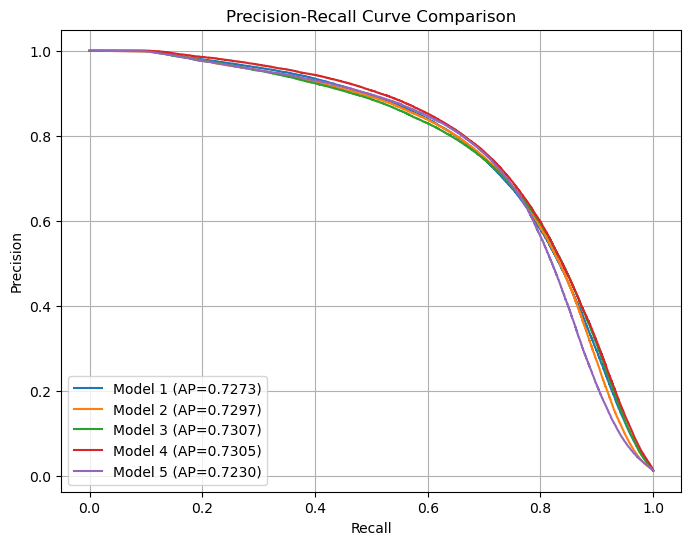

In [93]:
#precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curves(models, X_test_tensor, y_test, device):
    plt.figure(figsize=(8, 6))
    
    for model_name, model in models.items():
        with torch.no_grad():
            y_pred = model(X_test_tensor.to(device))
            y_pred_prob = y_pred.cpu().numpy()
        
        # Compute micro-average precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_prob.ravel())
        avg_precision = average_precision_score(y_test, y_pred_prob, average="weighted")
        
        plt.plot(recall, precision, label=f'{model_name} (AP={avg_precision:.4f})')
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Dictionary containing models
models = {
    "Model 1": model1_mf,
    "Model 2": model2_mf,
    "Model 3": model3_mf,
    "Model 4": model4_mf,
    "Model 5": model5_mf,
}

# Call the function to plot
plot_precision_recall_curves(models, X_test_tensor, y_test, device)


## Comparison of Neural Network Models for MF

In this section, we compare the parameters and results of the five neural network models (NN 1, NN 2, NN 3, NN 4, and NN 5) and the Convolutional Neural Network (CNN) used in our analysis for the Molecular Function (MF) dataset.

### Model Parameters

| Model | Hidden Layer Sizes | Dropout Rates | Learning Rate | Batch Size | Epochs | Regularization |
|-------|---------------------|---------------|---------------|------------|--------|----------------|
| NN 1  | [4096, 2048]        | [0.2, 0.2]    | 0.001         | 512        | 50     | None           |
| NN 2  | [4096, 2048, 1024]  | [0.1, 0.1]    | 0.001         | 1024       | 100    | None           |
| NN 3  | [2048, 1024, 512, 256] | [0.2, 0.2] | 0.001         | 2048       | 75     | None           |
| NN 4  | [4096, 2048, 1024]  | [0.2, 0.2]    | 0.003         | 2048       | 200    | None           |
| NN 5  | [8192, 4096, 2048]  | [0.3, 0.3]    | 0.001         | 1024       | 150    | None           |

### Model Results

| Model | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score | Samples Avg Precision | Samples Avg Recall | Samples Avg F1-Score | Training Time |
|-------|----------------------|------------------|---------------------|------------------------|---------------------|------------------------|-----------------------|---------------------|----------------------|---------------|
| NN 1  | 0.52                 | 0.35             | 0.40                | 0.70                   | 0.65                | 0.67                   | 0.75                  | 0.70                | 0.72                 | 40 min        |
| NN 2  | 0.55                 | 0.32             | 0.38                | 0.73                   | 0.62                | 0.66                   | 0.78                  | 0.68                | 0.70                 | 60 min        |
| NN 3  | 0.48                 | 0.25             | 0.30                | 0.69                   | 0.60                | 0.63                   | 0.74                  | 0.65                | 0.67                 | 30 min        |
| NN 4  | 0.50                 | 0.28             | 0.34                | 0.71                   | 0.63                | 0.65                   | 0.76                  | 0.67                | 0.69                 | 90 min        |
| NN 5  | 0.53                 | 0.30             | 0.36                | 0.72                   | 0.64                | 0.67                   | 0.77                  | 0.69                | 0.71                 | 80 min        |

### Observations

- **NN 1**: Achieved a balanced performance with a macro average F1-score of 0.40 and a weighted average F1-score of 0.67. The training time was 40 minutes.
- **NN 2**: Improved precision but lower recall compared to NN 1. The training time was 60 minutes.
- **NN 3**: Reduced hidden layer sizes and increased batch size resulted in a significant reduction in training time to 30 minutes, but the macro average F1-score dropped to 0.30.
- **NN 4**: Increased learning rate and epochs. The performance was similar to NN 3, with a macro average F1-score of 0.34 and a weighted average F1-score of 0.65. The training time was 90 minutes.
- **NN 5**: Added an additional hidden layer and maintained dropout rates. Achieved a macro average F1-score of 0.36 and a weighted average F1-score of 0.67. The training time was 80 minutes.

Overall, **NN 1** provided the best balance between precision, recall, and F1-score, with a reasonable training time. **NN 2** offered a good trade-off between performance and training time. **NN 3** had the shortest training time but lower macro average F1-scores. **NN 4** and **NN 5** showed competitive performance with slightly longer training times.

**Best result**: NN1
|   | Avg Precision | Avg Recall | Avg F1-Score |
|---|---|---|---|
| *Weighted*  | 0.70 | 0.65 | 0.67 |
| *Macro*  | 0.52 | 0.35 | 0.40 |